## Predicting Avocado Prices

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from matplotlib.colors import ListedColormap

In [2]:
path = "C:/Users/Eileen/Documents/Kaggle Projects/avocado-prices/avocado.csv"
data = pd.read_csv(path)
print(list(data))
print(len(data))

['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region']
18249


Text(0.5,1,'Average Daily Price of Avocados')

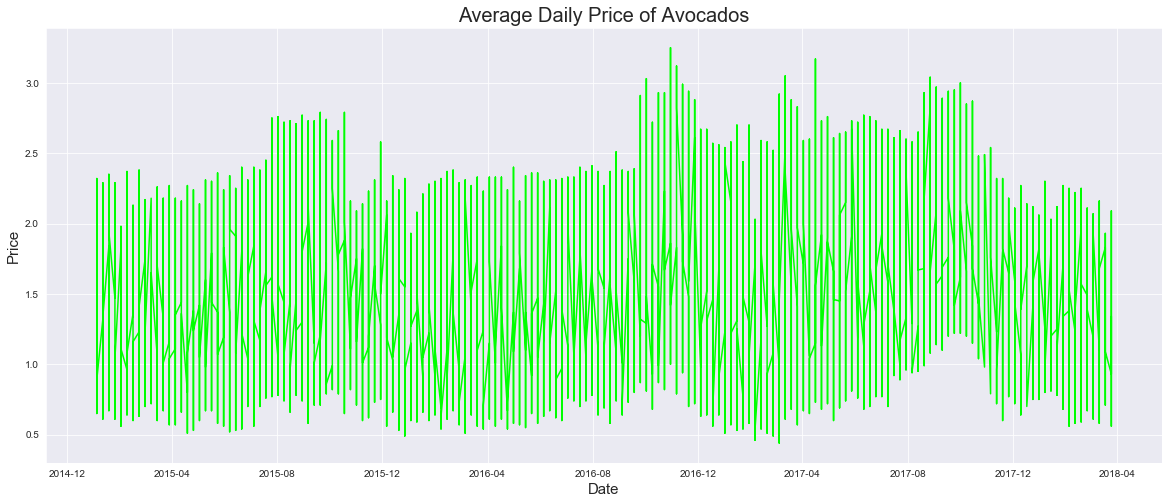

In [3]:
#plot daily price 
sns.set_style("darkgrid")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values(by = "Date")
plt.figure(figsize = (20, 8))
plt.plot(data["Date"], data["AveragePrice"], color = "lime")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("Price", fontsize = 15)
plt.title("Average Daily Price of Avocados", fontsize = 20)

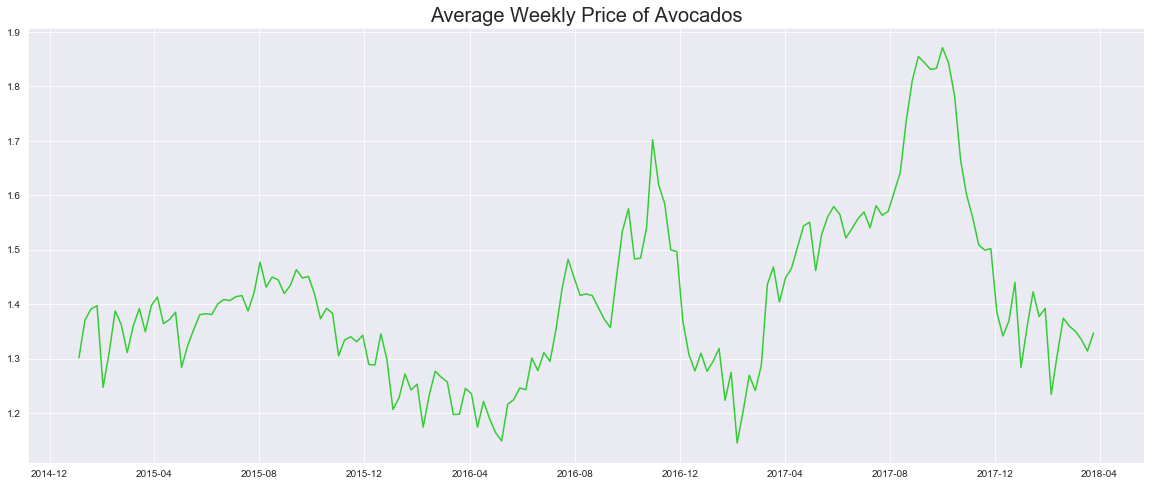

In [4]:
data_weekly = data.resample("W", on = "Date").mean()
plt.figure(figsize = (20, 8))
plt.plot(data_weekly.index, data_weekly["AveragePrice"], color = "limegreen")
plt.title("Average Weekly Price of Avocados", fontsize = 20)
plt.show() 

Text(0.5,1,'Average Monthly Price of Avocados')

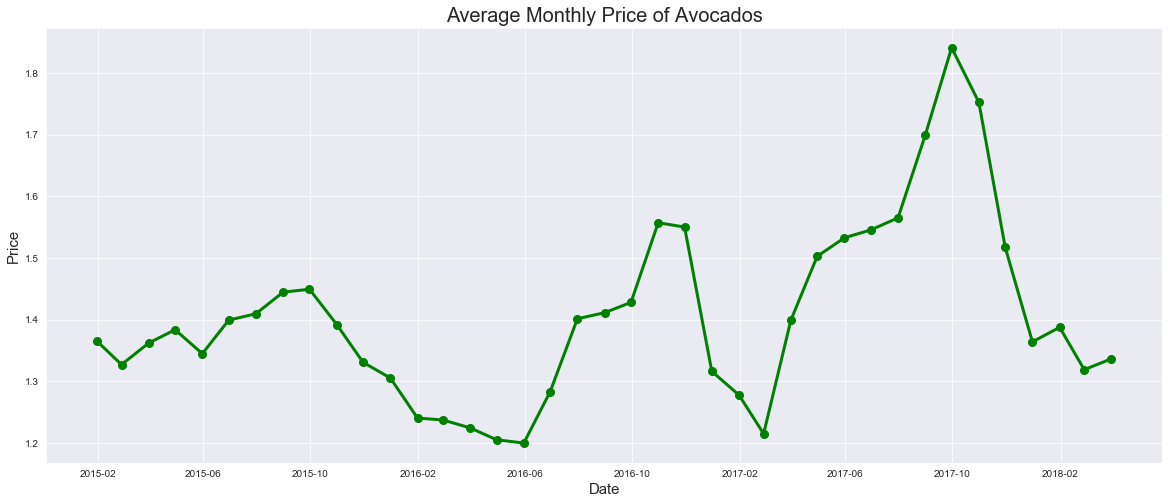

In [5]:
#Resampling by monthly 
data_monthly = data.resample("M", on = "Date").mean()
plt.figure(figsize = (20, 8))
plt.plot(data_monthly.index, data_monthly["AveragePrice"], color = "green", marker = "o", markersize = 8, linewidth = 3)
plt.xlabel("Date", fontsize = 15)
plt.ylabel("Price", fontsize = 15)
plt.title("Average Monthly Price of Avocados", fontsize = 20)

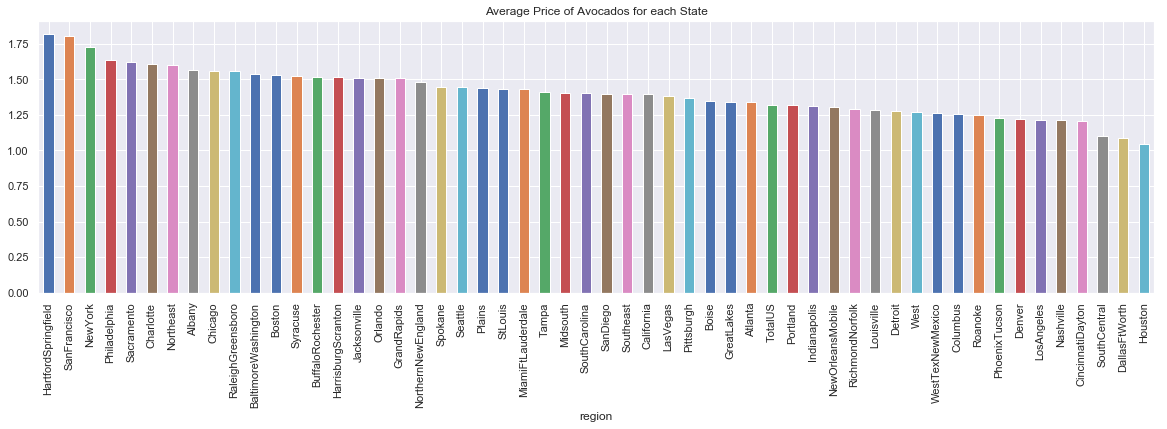

In [6]:
#Prices by state 
plt.figure(figsize = (20, 5))
sns.set()
data_states = data["AveragePrice"].groupby(data["region"]).agg("mean")
data_states = data_states.sort_values(ascending = False)
data_states.plot(kind = "bar", title = "Average Price of Avocados for each State")

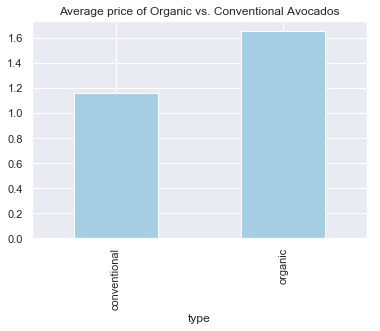

In [7]:
data_type = data["AveragePrice"].groupby(data["type"]).agg("mean")
data_type.plot(kind = "bar", colormap = ListedColormap(sns.color_palette("Paired")), title = 
               "Average price of Organic vs. Conventional Avocados")
plt.show()

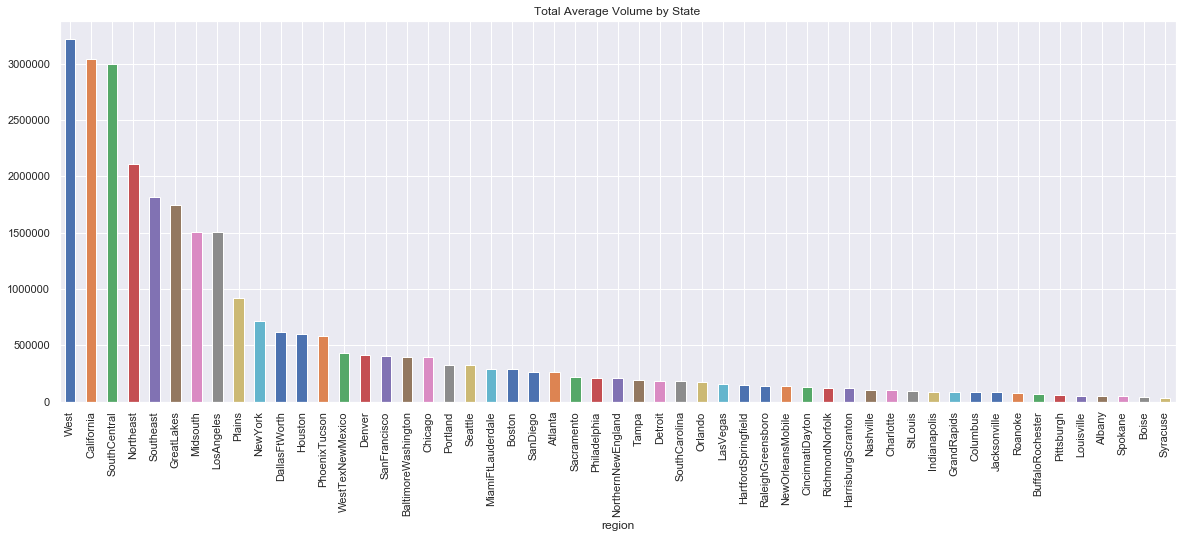

In [8]:
data_volume = data["Total Volume"].groupby(data["region"]).agg("mean")
data_volume = data_volume.drop("TotalUS")
data_volume = data_volume.sort_values(ascending = False)
data_volume.plot(kind = "bar", figsize = (20, 7), title = "Total Average Volume by State")

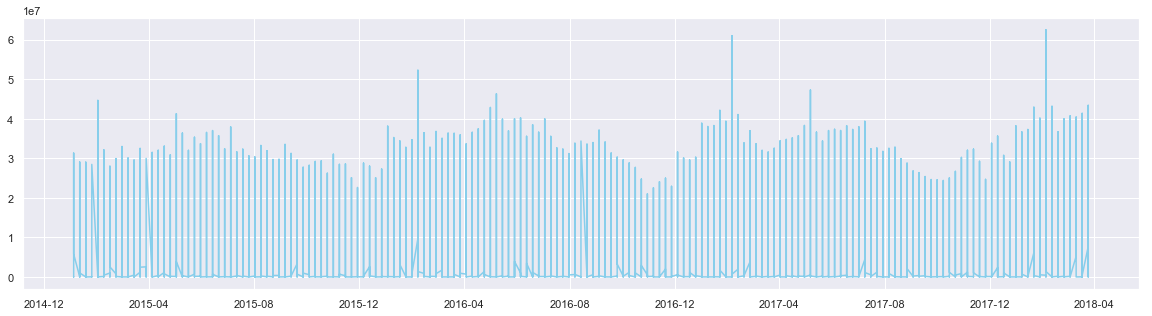

In [9]:
plt.figure(figsize = (20, 5))
plt.plot(data["Date"], data["Total Volume"], color = "skyblue")

Text(0.5,1,'Average Price of Avacados for each Month')

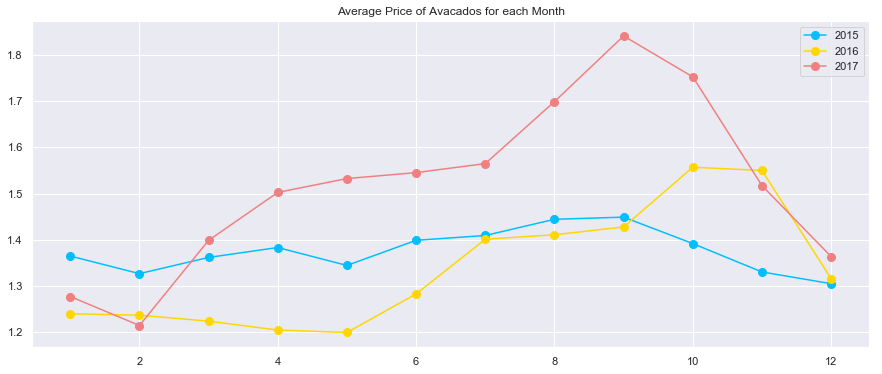

In [10]:
months = np.arange(1, 13)

data_2015 = data[data["Date"] < "2016-01-01"] 
data_2015 = data_2015.resample("M", on = "Date").mean()
data_2015["Month"] = months
 
data_2016 = data[(data["Date"] >= "2016-01-01") & (data["Date"] < "2017-01-01")]
data_2016 = data_2016.resample("M", on = "Date").mean()
data_2016["Month"] = months

data_2017 = data[(data["Date"] >= "2017-01-01") & (data["Date"] < "2018-01-01")]
data_2017 = data_2017.resample("M", on = "Date").mean()
data_2017["Month"] = months

plt.figure(figsize = (15, 6))
plt.plot(data_2015["Month"], data_2015["AveragePrice"], color = "deepskyblue", marker = "o", markersize = 8, label = "2015")
plt.plot(data_2016["Month"], data_2016["AveragePrice"], color = "gold", marker = "o", markersize = 8, label = "2016")
plt.plot(data_2017["Month"], data_2017["AveragePrice"], color = "lightcoral", marker = "o", markersize = 8, label = "2017")
plt.legend()
plt.title("Average Price of Avacados for each Month")

## Prediction with Recurrent Neural Nets

In [314]:
ts = data_weekly["AveragePrice"]
ts = np.array(ts)
num_periods = 28 #number of periods to predict 
x_data = ts[0:140]

#create 8 batches each of size 20. This will be the training data 
x_batches = x_data.reshape(-1, num_periods, 1)
print("Batch x dimensions:", x_batches.shape)
print("Batch x length:", len(x_batches)) 

y_data = ts[1:141]
y_batches = y_data.reshape(-1, num_periods, 1)
print("Batch y dimensions:", y_batches.shape)
print("Batch y length:", len(y_batches))

Batch x dimensions: (5, 28, 1)
Batch x length: 5
Batch y dimensions: (5, 28, 1)
Batch y length: 5


In [242]:
#Let's now create our test set 
forecast_horizon = 1 
test_x = ts[-(num_periods + forecast_horizon): - forecast_horizon].reshape(-1, num_periods, 1)
test_y = ts[-(num_periods):].reshape(-1,num_periods,1) #get the last 20 
print("test_x data dimensions:", test_x.shape)
print("test_x length:", len(test_x))
print("test_y data dimensions:", test_y.shape)
print("test_y length:", len(test_y))

test_x data dimensions: (1, 28, 1)
test_x length: 1
test_y data dimensions: (1, 28, 1)
test_y length: 1


In [243]:
tf.reset_default_graph()

In [244]:
#Create tensorflow graph 
x = tf.placeholder(tf.float32, [None, num_periods, 1])
y = tf.placeholder(tf.float32, [None, num_periods, 1])

In [245]:
rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units = 200, activation = tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(cell = rnn_cell, inputs = x, dtype = tf.float32)

In [246]:
rnn_output_reshaped = tf.reshape(rnn_output, [-1, 200])
output = tf.layers.dense(inputs = rnn_output_reshaped, units = 1)
final_output = tf.reshape(output,  [-1, num_periods, 1])

In [289]:
loss = tf.reduce_sum(tf.square(final_output - y)) #y train data 
optimiser = tf.train.AdamOptimizer(learning_rate = 0.0005)
train_op = optimiser.minimize(loss)

In [290]:
init = tf.global_variables_initializer()

In [291]:
input_dict = {x: x_batches, y: y_batches}
epochs = 3000
with tf.Session() as sess: 
    init.run() #initialize the variables 
    for ep in range(0, epochs):
        sess.run(train_op, feed_dict = input_dict)
        if ep % 500 == 0: 
            mse = loss.eval(feed_dict = input_dict)
            print("Epoch {} MSE".format(ep), mse)

    #get the final predictions
    y_pred = sess.run(final_output, feed_dict = {x: test_x})

Epoch 0 MSE 150.9675
Epoch 500 MSE 0.20941697
Epoch 1000 MSE 0.13225166
Epoch 1500 MSE 0.08731132
Epoch 2000 MSE 0.09745155
Epoch 2500 MSE 0.047070358


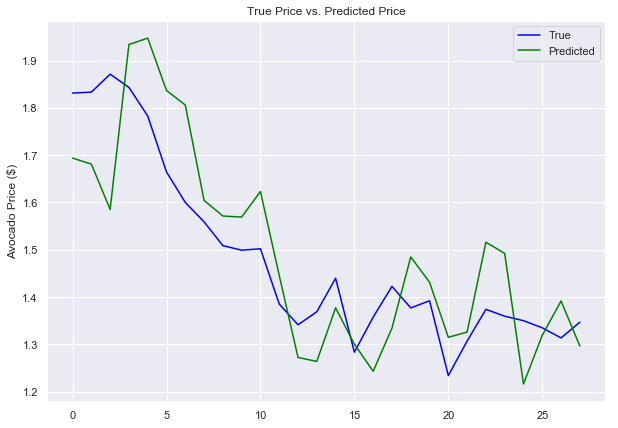

In [311]:
plt.figure(figsize = (10, 7))
plt.plot(test_y.flatten(), color = "blue", label = "True")
plt.plot(y_pred.flatten(), color = "green", label = "Predicted")
plt.legend()
plt.title("True Price vs. Predicted Price")
plt.ylabel("Avocado Price ($)")
plt.show()